<a href="https://colab.research.google.com/github/HarryHy/Neuro140/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
root_file = "/content/gdrive/My Drive/noreward-rl-master/"

In [ ]:
!pip install keras_applications

     |████████████████████████████████| 50 kB 4.6 MB/s 


In [ ]:
import os
import sys
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from argparse import ArgumentParser
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

#from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.layers.core import Activation
from keras.layers import BatchNormalization
from keras import backend as K

from matplotlib import pyplot as plt
import matplotlib.cm as cm
# discrete sine transform
from scipy.fftpack import dst
# k-means
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelBinarizer


from keras.models import Model
from keras_applications.resnet import ResNet50

from imutils import paths

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

Baseline Model

In [ ]:
class Model:
	@staticmethod
	def build(width, height, depth, classes, reg, init="he_normal"):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1
 
		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# our first CONV layer will learn a total of 16 filters, each
		# Of which are 7x7 -- we'll then apply 2x2 strides to reduce
		# the spatial dimensions of the volume
		#model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
		model.add(Conv2D(16, (3, 3), strides=(2, 2), padding="valid",
			kernel_initializer=init, kernel_regularizer=reg,
			input_shape=inputShape))
 
		# here we stack two CONV layers on top of each other where
		# each layerswill learn a total of 32 (3x3) filters
		model.add(Conv2D(32, (3, 3), padding="same",
			kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same",
			kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))

				# stack two more CONV layers, keeping the size of each filter
		# as 3x3 but increasing to 64 total learned filters
		model.add(Conv2D(64, (3, 3), padding="same",
			kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same",
			kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Dropout(0.25))
 
		# increase the number of filters again, this time to 128
		model.add(Conv2D(128, (3, 3), padding="same",
			kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same",
			kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Dropout(0.25))

				# fully-connected layer
		model.add(Flatten())
		model.add(Dense(512, kernel_initializer=init))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.25))
 
		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
 
		# return the constructed network architecture
		return model
		model.add(Dropout(0.25))


In [ ]:
image_paths = list(paths.list_images('/content/gdrive/My Drive/101_ObjectCategories/'))
data = []
labels = []

LABELS = set(["Faces", "Leopards", "Motorbikes", "airplanes"])


for image_path in image_paths:
  # extract the class label from the filename
  label = image_path.split(os.path.sep)[-2]
  
  # if the label of the current image is not part of of the labels
  # are interested in, then ignore the image
  if label not in LABELS:
    continue
  
  image = cv2.imread(image_path)
  image = cv2.resize(image, (224, 224))
  
  # update the data and labels lists, respectively
  data.append(image)
  labels.append(label)

'''
for i in ["Faces", "Leopards", "Motorbikes", "airplanes"]:
  path_l = '/content/gdrive/My Drive/101_ObjectCategories/'+ i
  print(path_l)
  image_path = list(paths.list_images(path_l))

  for image_ in image_paths:
    image = cv2.imread(image_)
    image = cv2.resize(image, (224, 224))

    data.append(image)
    labels.append(i)
'''
channel_size = 5
data = np.array(data, dtype="float") / 255.0

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("[INFO] transforming images...")

cv_data = data
#cv_data_one = np.expand_dims(cv_data, axis=3)
cv_data_one = data
	# partition the data into training and testing splits using 75% of
	# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(cv_data_one, labels,
  test_size=0.25, stratify=labels, random_state=42)
	 
	# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
  width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
  horizontal_flip=True, fill_mode="nearest")

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-4, decay=1e-4 / 100)
#this oart is hardcode

	
w = 224
h = 224


[INFO] transforming images...
[INFO] compiling model...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img = data[2]    
gray = rgb2gray(img)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

[INFO] loading images...
[INFO] transforming images...
[INFO] compiling model...
[INFO] training network for 20 epochs...
(224, 224, 3) (8,)
Epoch 1/20
57/57 [==============================] - 19s 314ms/step - loss: 1.6710 - accuracy: 0.6796 - val_loss: 2.3355 - val_accuracy: 0.3246
Epoch 2/20
57/57 [==============================] - 17s 295ms/step - loss: 1.2133 - accuracy: 0.8003 - val_loss: 2.0188 - val_accuracy: 0.5525
Epoch 3/20
57/57 [==============================] - 17s 293ms/step - loss: 1.0104 - accuracy: 0.8532 - val_loss: 1.6698 - val_accuracy: 0.7180
Epoch 4/20
57/57 [==============================] - 17s 295ms/step - loss: 0.9795 - accuracy: 0.8632 - val_loss: 1.4597 - val_accuracy: 0.7738
Epoch 5/20
57/57 [==============================] - 17s 293ms/step - loss: 0.9206 - accuracy: 0.8754 - val_loss: 1.0710 - val_accuracy: 0.8180
Epoch 6/20
57/57 [==============================] - 17s 296ms/step - loss: 0.8711 - accuracy: 0.8843 - val_loss: 1.2119 - val_accuracy: 0.8049
E

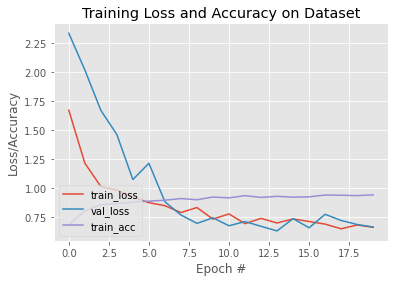

In [ ]:
if __name__ == "__main__":
	#fix_gpu()
	

	LABELS = set(["Faces", "Leopards", "Motorbikes", "airplanes", "wild_cat", "stop_sign", "lotus", "cannon" ])
	#LABELS = set(["Clock", "Flag", "Airplane", "Pig" ])
	epoch = 20
	# grab the list of images in our dataset directory, then initialize
	# the list of data (i.e., images) and class images
	print("[INFO] loading images...")
	image_paths = list(paths.list_images('/content/gdrive/My Drive/101_ObjectCategories/'))

	#image_paths = list(paths.list_images('/content/gdrive/My Drive/Image20/'))
	data = []
	labels = []

	
	for image_path in image_paths:
		# extract the class label from the filename
		label = image_path.split(os.path.sep)[-2]
	 
		# if the label of the current image is not part of of the labels
		# are interested in, then ignore the image
		if label not in LABELS:
			continue
	 
		image = cv2.imread(image_path)
		image = cv2.resize(image, (224, 224))
	 
		# update the data and labels lists, respectively
		data.append(image)
		labels.append(label)
	

	channel_size = 4
	data = np.array(data, dtype="float") / 255.0
	

	w = 224
	h = 224


	# perform one-hot encoding on the labels
	lb = LabelBinarizer()
	labels = lb.fit_transform(labels)
	print("[INFO] transforming images...")
	cv_data = data
	#cv_data_one = np.expand_dims(cv_data, axis=3)
	cv_data_one = data
	# partition the data into training and testing splits using 75% of
	# the data for training and the remaining 25% for testing
	(trainX, testX, trainY, testY) = train_test_split(cv_data_one, labels,
		test_size=0.25, stratify=labels, random_state=42)
	 
	# construct the training image generator for data augmentation
	aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
		width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
		horizontal_flip=True, fill_mode="nearest")

	print("[INFO] compiling model...")
	opt = Adam(learning_rate=1e-4, decay=1e-4 / epoch)
	#this oart is hardcode

	use_pretrained = True
	
	w = 224
	h = 224
	model = Model.build(width=w, height=h, depth=3,
		classes=len(lb.classes_), reg=l2(0.0005))
	
	model.compile(loss="categorical_crossentropy", optimizer=opt,
		metrics=["accuracy"])
	

	# train the network
	print("[INFO] training network for {} epochs...".format(
		epoch))
	#model.eval()
	print(trainX[0].shape, trainY[0].shape)
	H = model.fit(aug.flow(trainX, trainY, batch_size=32),
		validation_data=(testX, testY), steps_per_epoch=len(trainX) // 32,
		epochs=epoch)

	print("[INFO] evaluating network...")
	predictions = model.predict(testX, batch_size=32)
	print(classification_report(testY.argmax(axis=1),
		predictions.argmax(axis=1), target_names=lb.classes_))

	N = epoch
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
	plt.title("Training Loss and Accuracy on Dataset")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")

[INFO] loading images...
now is  100
now is  200
now is  300
now is  400
now is  500
now is  600
now is  700
now is  800
now is  900
now is  1000
now is  1100
now is  1200
now is  1300
now is  1400
now is  1500
now is  1600
now is  1700
now is  1800
now is  1900
now is  2000
now is  2100
now is  2200
now is  2300
now is  2400
[INFO] transforming images...
2440
[INFO] compiling model...
[INFO] training network for 20 epochs...
(224, 224, 1) (8,)
Epoch 1/20
57/57 [==============================] - 8s 113ms/step - loss: 1.6763 - accuracy: 0.6947 - val_loss: 6.0852 - val_accuracy: 0.2131
Epoch 2/20
57/57 [==============================] - 6s 101ms/step - loss: 1.2667 - accuracy: 0.7948 - val_loss: 1.9780 - val_accuracy: 0.6541
Epoch 3/20
57/57 [==============================] - 6s 102ms/step - loss: 1.1498 - accuracy: 0.8154 - val_loss: 1.5454 - val_accuracy: 0.7180
Epoch 4/20
57/57 [==============================] - 6s 101ms/step - loss: 1.0590 - accuracy: 0.8320 - val_loss: 1.4458 - val_

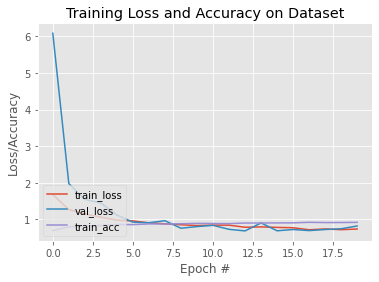

In [ ]:
from skimage import color
if __name__ == "__main__":
	#fix_gpu()
	

	LABELS = set(["Faces", "Leopards", "Motorbikes", "airplanes", "wild_cat", "stop_sign", "lotus", "cannon" ])
	#LABELS = set(["Clock", "Flag", "Airplane", "Pig" ])
	epoch = 20
	# grab the list of images in our dataset directory, then initialize
	# the list of data (i.e., images) and class images
	print("[INFO] loading images...")
	image_paths = list(paths.list_images('/content/gdrive/My Drive/101_ObjectCategories/'))

	#image_paths = list(paths.list_images('/content/gdrive/My Drive/Image20/'))
	data = []
	labels = []

	i = 0
	for image_path in image_paths:
		# extract the class label from the filename
		label = image_path.split(os.path.sep)[-2]
	 
		# if the label of the current image is not part of of the labels
		# are interested in, then ignore the image
		if label not in LABELS:
			continue
	 
		image = cv2.imread(image_path)
		image = cv2.resize(image, (224, 224))
	 
		# update the data and labels lists, respectively
		data.append(image)
		labels.append(label)
		i +=1
		if i%100 == 0:
			print("now is ", i)

	channel_size = 4
	data = np.array(data, dtype="float") / 255.0
	

	w = 224
	h = 224


	# perform one-hot encoding on the labels
	lb = LabelBinarizer()
	labels = lb.fit_transform(labels)
	print("[INFO] transforming images...")
	cv_data = []

	for img in data:
		gray = color.rgb2gray(img)
		cv_data.append(gray)
	print(len(cv_data))
	cv_data_one = np.expand_dims(cv_data, axis=3)
	#cv_data_one = cv_data
	# partition the data into training and testing splits using 75% of
	# the data for training and the remaining 25% for testing
	(trainX, testX, trainY, testY) = train_test_split(cv_data_one, labels,
		test_size=0.25, stratify=labels, random_state=42)
	 
	# construct the training image generator for data augmentation
	aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
		width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
		horizontal_flip=True, fill_mode="nearest")

	print("[INFO] compiling model...")
	opt = Adam(learning_rate=1e-4, decay=1e-4 / epoch)
	#this oart is hardcode

	use_pretrained = True
	
	w = 224
	h = 224
	model = Model.build(width=w, height=h, depth=1,
		classes=len(lb.classes_), reg=l2(0.0005))
	
	model.compile(loss="categorical_crossentropy", optimizer=opt,
		metrics=["accuracy"])
	

	# train the network
	print("[INFO] training network for {} epochs...".format(
		epoch))
	#model.eval()
	print(trainX[0].shape, trainY[0].shape)
	H = model.fit(aug.flow(trainX, trainY, batch_size=32),
		validation_data=(testX, testY), steps_per_epoch=len(trainX) // 32,
		epochs=epoch)

	print("[INFO] evaluating network...")
	predictions = model.predict(testX, batch_size=32)
	print(classification_report(testY.argmax(axis=1),
		predictions.argmax(axis=1), target_names=lb.classes_))

	N = epoch
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
	plt.title("Training Loss and Accuracy on Dataset")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")

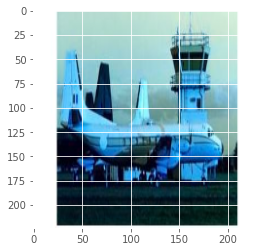

In [ ]:
plt.imshow(data[0])

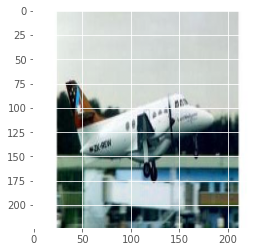

In [ ]:
plt.imshow(data[1])

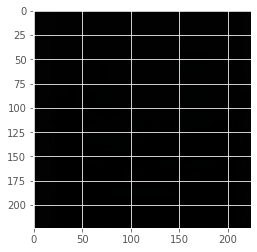

In [ ]:
plt.imshow(data[0] + data[1])

In [ ]:
d0 = data[0].astype(np.uint8)
d1 = data[1].astype(np.uint8)

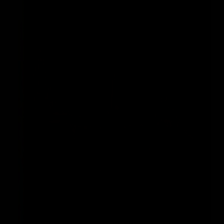

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(data[0])

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from tqdm.notebook import tqdm

def dct_transform(images):
    # current config: full DCT, take upper-left 5x5 matrix of Y component, 4:4:4 chroma subsampling (meaning no subsampling)
    dcts = np.zeros(images.shape[0],1,5,5)
    for i in range(images.shape[0]):
        transcol=cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img_gray=transcol[:,:,0]
        dct = cv2.dct(img_gray)
        dcts[i,0,:,:] = dct[0:5,0:5]

    return dcts

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                # do dct transformation here

                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#data_dir = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/utku1/code/Users/utku/datasets/hymenoptera_data"
#data_dir = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/utku1/code/Users/utku/datasets/imagenet/imagenet_training_8class_subset"
#data_dir = "/n/home04/usirin/datasets/imagenet_training_8class_subset"
#data_dir= "/n/home04/usirin/datasets/blood-cell-images/dataset2-master/dataset2-master/images/TRAIN"
if __name__ == '__main__':
    data_dir = "/content/gdrive/My Drive/p/"
    # Models to choose from [resnet, resnet50, alexnet, vgg, squeezenet, densenet, inception]
    model_name = "resnet50"

    # Number of classes in the dataset
    num_classes = 2

    # Batch size for training (change depending on how much memory you have)
    batch_size = 64

    # Number of epochs to train for
    num_epochs = 50

    # Flag for feature extracting. When False, we finetune the whole model,
    #   when True we only update the reshaped layer params
    feature_extract = False

    # Initialize the model for this run
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)

    # Print the model we just instantiated
    print(model_ft)

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send the model to GPU
    model_ft = model_ft.to(device)

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    print("train the model")
    model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))


PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequen

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.8111 Acc: 0.4286


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6938 Acc: 0.5000

Epoch 1/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.7468 Acc: 0.4940


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6851 Acc: 0.5750

Epoch 2/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.7058 Acc: 0.5298


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6857 Acc: 0.5750

Epoch 3/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.7040 Acc: 0.5119


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6902 Acc: 0.5000

Epoch 4/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.7429 Acc: 0.4583


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6985 Acc: 0.4750

Epoch 5/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6664 Acc: 0.6131


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6997 Acc: 0.4500

Epoch 6/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6705 Acc: 0.5714


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6969 Acc: 0.4750

Epoch 7/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6919 Acc: 0.5655


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.7187 Acc: 0.4500

Epoch 8/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6579 Acc: 0.6190


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.7523 Acc: 0.4500

Epoch 9/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.7007 Acc: 0.6012


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.7520 Acc: 0.4750

Epoch 10/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.7145 Acc: 0.5536


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6671 Acc: 0.5250

Epoch 11/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6858 Acc: 0.5952


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6653 Acc: 0.5250

Epoch 12/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6724 Acc: 0.6012


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6394 Acc: 0.6250

Epoch 13/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6576 Acc: 0.5952


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6272 Acc: 0.6750

Epoch 14/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6721 Acc: 0.6071


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6262 Acc: 0.6750

Epoch 15/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6520 Acc: 0.6012


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6345 Acc: 0.6750

Epoch 16/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6501 Acc: 0.6071


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6284 Acc: 0.6250

Epoch 17/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6495 Acc: 0.6071


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6011 Acc: 0.6750

Epoch 18/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6154 Acc: 0.6845


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6086 Acc: 0.6500

Epoch 19/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6482 Acc: 0.6726


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6217 Acc: 0.6750

Epoch 20/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6284 Acc: 0.6369


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6443 Acc: 0.6250

Epoch 21/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6252 Acc: 0.6548


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6610 Acc: 0.6750

Epoch 22/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5697 Acc: 0.7024


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6894 Acc: 0.5750

Epoch 23/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6080 Acc: 0.6607


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6916 Acc: 0.6000

Epoch 24/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6284 Acc: 0.6369


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.7736 Acc: 0.6250

Epoch 25/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6482 Acc: 0.6369


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6304 Acc: 0.7000

Epoch 26/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5513 Acc: 0.7262


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6601 Acc: 0.6750

Epoch 27/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5911 Acc: 0.7083


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6364 Acc: 0.6000

Epoch 28/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5570 Acc: 0.6905


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6119 Acc: 0.6250

Epoch 29/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6000 Acc: 0.6845


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6013 Acc: 0.6750

Epoch 30/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5142 Acc: 0.7560


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6766 Acc: 0.5250

Epoch 31/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5503 Acc: 0.7381


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6553 Acc: 0.7500

Epoch 32/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5235 Acc: 0.7500


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6153 Acc: 0.6250

Epoch 33/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5092 Acc: 0.7440


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6241 Acc: 0.6500

Epoch 34/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5750 Acc: 0.7440


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6055 Acc: 0.6250

Epoch 35/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5862 Acc: 0.7202


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.5946 Acc: 0.6500

Epoch 36/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.4936 Acc: 0.7619


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6551 Acc: 0.6750

Epoch 37/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5101 Acc: 0.7083


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.5696 Acc: 0.6750

Epoch 38/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.4953 Acc: 0.7917


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.7464 Acc: 0.6500

Epoch 39/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5100 Acc: 0.7321


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.5597 Acc: 0.7500

Epoch 40/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5127 Acc: 0.7798


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.5684 Acc: 0.6750

Epoch 41/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5096 Acc: 0.7738


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6784 Acc: 0.6500

Epoch 42/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.4724 Acc: 0.7679


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6252 Acc: 0.6250

Epoch 43/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5454 Acc: 0.7024


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6387 Acc: 0.6000

Epoch 44/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.4860 Acc: 0.7679


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6522 Acc: 0.6500

Epoch 45/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.4537 Acc: 0.8214


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6068 Acc: 0.6750

Epoch 46/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.4707 Acc: 0.7500


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6906 Acc: 0.6250

Epoch 47/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.4524 Acc: 0.7738


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.5552 Acc: 0.7250

Epoch 48/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5122 Acc: 0.7440


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.5416 Acc: 0.7500

Epoch 49/49
----------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.4691 Acc: 0.8155


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6150 Acc: 0.7000

Training complete in 2m 29s
Best val Acc: 0.750000


In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from tqdm.notebook import tqdm

def dct_transform(images):
    # current config: full DCT, take upper-left 5x5 matrix of Y component, 4:4:4 chroma subsampling (meaning no subsampling)
    dcts = np.zeros(images.shape[0],1,5,5)
    for i in range(images.shape[0]):
        transcol=cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img_gray=transcol[:,:,0]
        dct = cv2.dct(img_gray)
        dcts[i,0,:,:] = dct[0:5,0:5]

    return dcts

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                # do dct transformation here

                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#data_dir = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/utku1/code/Users/utku/datasets/hymenoptera_data"
#data_dir = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/utku1/code/Users/utku/datasets/imagenet/imagenet_training_8class_subset"
#data_dir = "/n/home04/usirin/datasets/imagenet_training_8class_subset"
#data_dir= "/n/home04/usirin/datasets/blood-cell-images/dataset2-master/dataset2-master/images/TRAIN"
if __name__ == '__main__':
    data_dir = "/content/gdrive/My Drive/p/"
    # Models to choose from [resnet, resnet50, alexnet, vgg, squeezenet, densenet, inception]
    model_name = "resnet50"

    # Number of classes in the dataset
    num_classes = 4

    # Batch size for training (change depending on how much memory you have)
    batch_size = 64

    # Number of epochs to train for
    num_epochs = 50

    # Flag for feature extracting. When False, we finetune the whole model,
    #   when True we only update the reshaped layer params
    feature_extract = False

    # Initialize the model for this run
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)

    # Print the model we just instantiated
    print(model_ft)

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send the model to GPU
    model_ft = model_ft.to(device)

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    print("train the model")
    model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))


PyTorch Version:  1.11.0+cu113
Torchvision Version:  0.12.0+cu113
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequen

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.4305 Acc: 0.2864


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3566 Acc: 0.3713

Epoch 1/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.4170 Acc: 0.3025


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.5756 Acc: 0.2476

Epoch 2/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.3938 Acc: 0.3242


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4313 Acc: 0.2834

Epoch 3/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.4474 Acc: 0.3221


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4219 Acc: 0.3909

Epoch 4/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.4337 Acc: 0.3123


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4028 Acc: 0.3811

Epoch 5/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.3404 Acc: 0.3831


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4109 Acc: 0.4007

Epoch 6/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.2431 Acc: 0.4454


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3388 Acc: 0.4300

Epoch 7/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.2897 Acc: 0.4433


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1634 Acc: 0.4984

Epoch 8/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.2723 Acc: 0.4293


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1639 Acc: 0.4625

Epoch 9/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.1952 Acc: 0.4783


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2970 Acc: 0.4625

Epoch 10/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.2640 Acc: 0.4531


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4241 Acc: 0.3453

Epoch 11/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.4063 Acc: 0.4160


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4240 Acc: 0.4235

Epoch 12/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.2100 Acc: 0.4608


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1732 Acc: 0.4723

Epoch 13/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.1832 Acc: 0.4776


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2157 Acc: 0.5244

Epoch 14/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.2008 Acc: 0.4734


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1334 Acc: 0.5896

Epoch 15/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.1247 Acc: 0.5070


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0358 Acc: 0.5407

Epoch 16/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.1013 Acc: 0.5266


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1018 Acc: 0.5407

Epoch 17/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

train Loss: 1.1853 Acc: 0.4916


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0453 Acc: 0.5179

Epoch 18/49
----------


  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from tqdm.notebook import tqdm

def dct_transform(images):
    # current config: full DCT, take upper-left 5x5 matrix of Y component, 4:4:4 chroma subsampling (meaning no subsampling)
    dcts = np.zeros(images.shape[0],1,5,5)
    for i in range(images.shape[0]):
        transcol=cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img_gray=transcol[:,:,0]
        dct = cv2.dct(img_gray)
        dcts[i,0,:,:] = dct[0:5,0:5]

    return dcts

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                # do dct transformation here

                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#data_dir = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/utku1/code/Users/utku/datasets/hymenoptera_data"
#data_dir = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/utku1/code/Users/utku/datasets/imagenet/imagenet_training_8class_subset"
#data_dir = "/n/home04/usirin/datasets/imagenet_training_8class_subset"
#data_dir= "/n/home04/usirin/datasets/blood-cell-images/dataset2-master/dataset2-master/images/TRAIN"
if __name__ == '__main__':
    data_dir = "/content/gdrive/My Drive/q/"
    # Models to choose from [resnet, resnet50, alexnet, vgg, squeezenet, densenet, inception]
    model_name = "resnet50"

    # Number of classes in the dataset
    num_classes = 4

    # Batch size for training (change depending on how much memory you have)
    batch_size = 64

    # Number of epochs to train for
    num_epochs = 50

    # Flag for feature extracting. When False, we finetune the whole model,
    #   when True we only update the reshaped layer params
    feature_extract = False

    # Initialize the model for this run
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)

    # Print the model we just instantiated
    print(model_ft)

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send the model to GPU
    model_ft = model_ft.to(device)

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    print("train the model")
    model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
